## Project: Discovering the Top Investment Banks’ Performance and the Factors that Could Affect It
### Principal Investigators: Isabel An (ban22@wisc.edu); Siyuan Kong (skong35@wisc.edu)
  
Source reference:  
https://www.macrotrends.net/  
https://fred.stlouisfed.org/

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import pandas_datareader.data as web  
import numpy as np

In [2]:
# get bank urls
banks = ['JPM/jpmorgan-chase','BAC/bank-of-america','C/citigroup','MS/morgan-stanley', 'CS/credit-suisse-group']
# the page for 'GS/goldman-sachs' died right on today Friday :(
revenue_url = 'https://www.macrotrends.net/stocks/charts/{}/revenue'
roi_url = 'https://www.macrotrends.net/stocks/charts/{}/roi'

def get_url(url):
    urls = []
    for i in banks:
        urls.append(url.format(i))
        
    return urls

get_url(revenue_url)

['https://www.macrotrends.net/stocks/charts/JPM/jpmorgan-chase/revenue',
 'https://www.macrotrends.net/stocks/charts/BAC/bank-of-america/revenue',
 'https://www.macrotrends.net/stocks/charts/C/citigroup/revenue',
 'https://www.macrotrends.net/stocks/charts/MS/morgan-stanley/revenue',
 'https://www.macrotrends.net/stocks/charts/CS/credit-suisse-group/revenue']

In [4]:
# get bank revenue df
rev = []
for url, bank in zip(get_url(revenue_url), banks):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find_all('table')[1]
#     print(table)
    data = []
    table_rows = table.find_all('tr')
    for row in table_rows:
        cells = row.find_all('td')
        if len(cells) > 0:
            data.append([cell.text.strip() for cell in cells])
    df = pd.DataFrame(data, columns=['Date', 'Revenue'])
    df['Bank'] = bank
    rev.append(df)

df_rev = pd.concat(rev, ignore_index=True)


In [5]:
# change df dtypes to datetime and float
df_rev['Revenue'] = df_rev['Revenue'].apply(lambda x: float(re.sub(r'[^\d.]', '', x)))
df_rev['Date'] = pd.to_datetime(df_rev['Date'])

In [6]:
rev_pivot = df_rev.pivot(index='Date', columns='Bank', values='Revenue')

In [7]:
df_rev.head()

,Date,Revenue,Bank
0,2023-03-31,54642.0,JPM/jpmorgan-chase
1,2022-12-31,47409.0,JPM/jpmorgan-chase
2,2022-09-30,40809.0,JPM/jpmorgan-chase
3,2022-06-30,34233.0,JPM/jpmorgan-chase
4,2022-03-31,32341.0,JPM/jpmorgan-chase


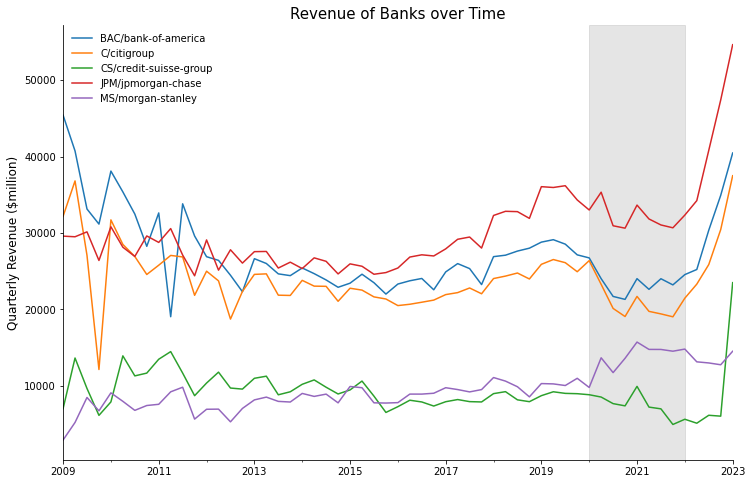

In [8]:
fig, ax = plt.subplots(figsize=(12,8))

rev_pivot.plot(ax=ax)

ax.legend(frameon=False)

ax.set_xlabel('')
ax.set_ylabel('Quarterly Revenue ($million)', fontsize=12)
ax.set_title('Revenue of Banks over Time', fontsize=15)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.axvspan('2020-01-01', '2022-01-01', alpha=0.2, color='gray')


plt.show()

In [9]:
# get bank roi df
roi = []
for url, bank in zip(get_url(roi_url), banks):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table')
    data = []
    table_rows = table.find_all('tr')
    for row in table_rows:
        cells = row.find_all('td')
        if len(cells) > 0:
            data.append([cell.text.strip() for cell in cells])
    df_roi = pd.DataFrame(data, columns=['Date', 'TTM Net Income', 'LT Investments & Debt', 'ROI'])
    df_roi['Bank'] = bank
    roi.append(df_roi)

df_roi = pd.concat(roi, ignore_index=True)


In [10]:
df_roi['Date'] = pd.to_datetime(df_roi['Date'])
df_roi['ROI'] = df_roi['ROI'].str.replace('%', '').astype(float)

In [11]:
df_roi.head()

,Date,TTM Net Income,LT Investments & Debt,ROI,Bank
0,2023-03-31,$52.07B,$598.57B,8.91,JPM/jpmorgan-chase
1,2022-12-31,$46.17B,$588.20B,7.97,JPM/jpmorgan-chase
2,2022-09-30,$45.59B,$575.49B,7.85,JPM/jpmorgan-chase
3,2022-06-30,$47.70B,$574.36B,8.16,JPM/jpmorgan-chase
4,2022-03-31,$51.93B,$579.14B,8.84,JPM/jpmorgan-chase


In [12]:
roi_pivot = df_roi[['Date', 'ROI', 'Bank']].pivot(index='Date', columns='Bank', values='ROI')

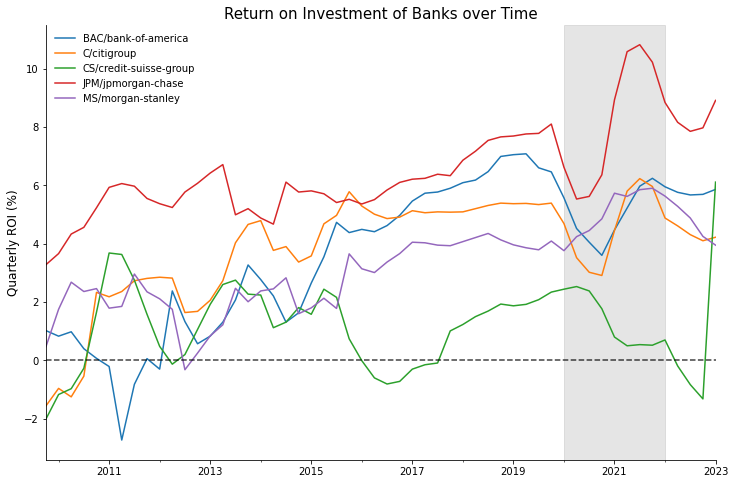

In [13]:
fig, ax = plt.subplots(figsize=(12,8))

roi_pivot.plot(ax=ax)

ax.legend(loc='upper left', frameon=False)

ax.set_xlabel('')
ax.set_ylabel('Quarterly ROI (%)', fontsize=12)
ax.set_title('Return on Investment of Banks over Time', fontsize=15)

ax.axhline(y=0, linestyle='--', color='black', alpha=0.75)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.axvspan('2020-01-01', '2022-01-01', alpha=0.2, color='gray')

plt.show()

In [14]:
# merged df for banks
banking = pd.merge(df_rev, df_roi, how='inner', on=['Date','Bank'])

In [15]:
banking

,Date,Revenue,Bank,TTM Net Income,LT Investments & Debt,ROI
0,2023-03-31,54642.0,JPM/jpmorgan-chase,$52.07B,$598.57B,8.91
1,2022-12-31,47409.0,JPM/jpmorgan-chase,$46.17B,$588.20B,7.97
2,2022-09-30,40809.0,JPM/jpmorgan-chase,$45.59B,$575.49B,7.85
3,2022-06-30,34233.0,JPM/jpmorgan-chase,$47.70B,$574.36B,8.16
4,2022-03-31,32341.0,JPM/jpmorgan-chase,$51.93B,$579.14B,8.84
...,...,...,...,...,...,...
265,2010-12-31,11657.0,CS/credit-suisse-group,$3.51B,$208.42B,1.65
266,2010-09-30,11293.0,CS/credit-suisse-group,$-0.57B,$216.35B,-0.27
267,2010-06-30,13915.0,CS/credit-suisse-group,$-2.00B,$207.24B,-0.97
268,2010-03-31,7886.0,CS/credit-suisse-group,$-2.37B,$220.44B,-1.17


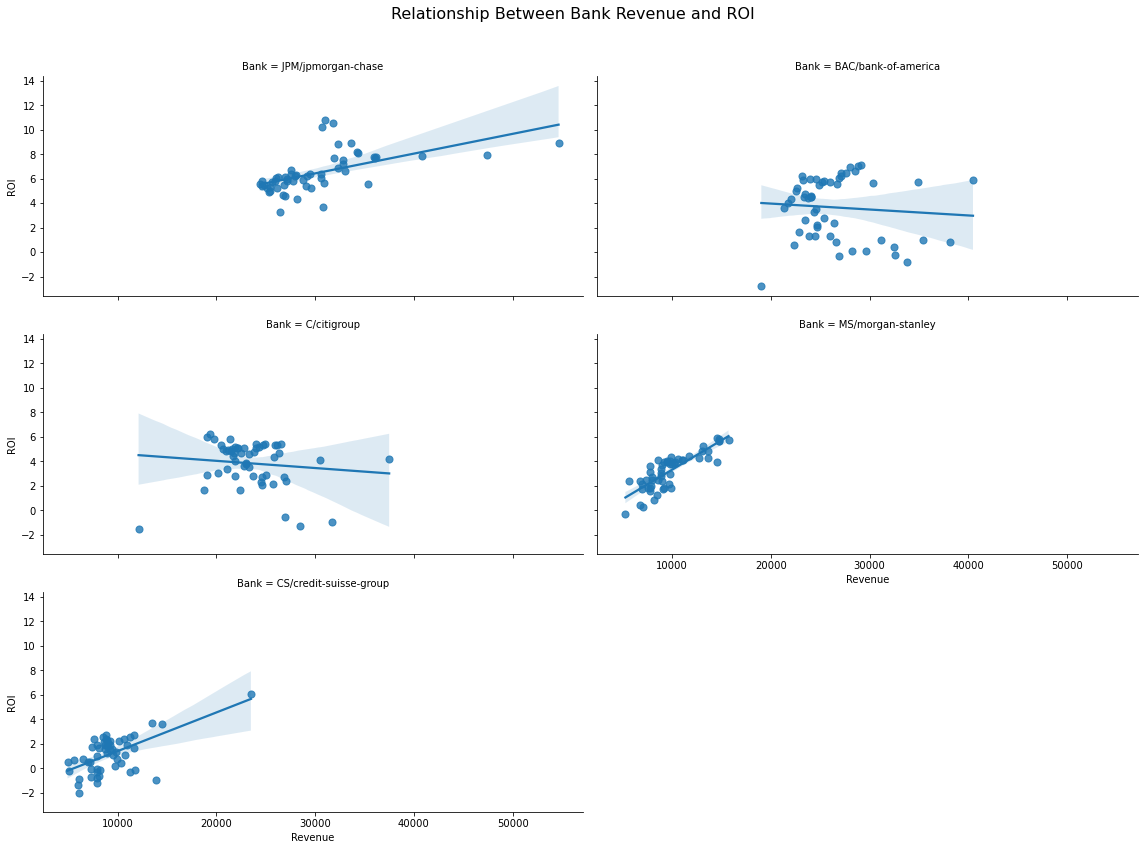

In [16]:
g = sns.FacetGrid(banking, col="Bank", col_wrap=2, height=4, aspect=2)
g.map(sns.regplot, "Revenue", "ROI", ci=95, scatter_kws={"s": 50})

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Relationship Between Bank Revenue and ROI', fontsize=16)

plt.show()

In [17]:
GDP = web.DataReader('GDPC1', 'fred', start='2010-01-01').dropna().resample('Q').last()

In [18]:
gdp_bank = pd.merge(rev_pivot, GDP, left_index=True, right_index=True, how='inner')

In [19]:
gdp_bank.head()

,BAC/bank-of-america,C/citigroup,CS/credit-suisse-group,JPM/jpmorgan-chase,MS/morgan-stanley,GDPC1
2010-03-31,38099.0,31712.0,7886.0,30806.0,9072.0,15456.059
2010-06-30,35372.0,28500.0,13915.0,28133.0,7963.0,15605.628
2010-09-30,32474.0,26921.0,11293.0,26928.0,6780.0,15726.282
2010-12-31,28249.0,24564.0,11657.0,29608.0,7415.0,15807.995
2011-03-31,32620.0,25779.0,13471.0,28763.0,7574.0,15769.911


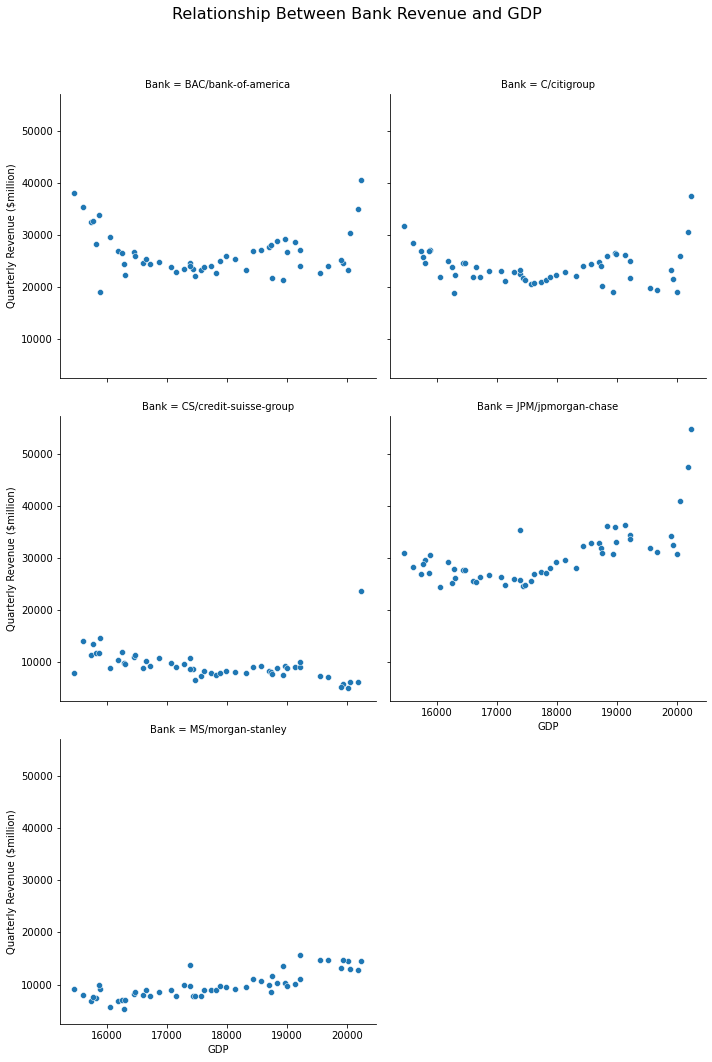

In [20]:
import seaborn as sns

g = sns.relplot(data=gdp_bank.melt(id_vars='GDPC1', var_name='Bank'), x='GDPC1', y='value', col='Bank', col_wrap=2, kind='scatter')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Relationship Between Bank Revenue and GDP', fontsize=16)
g.set_axis_labels('GDP', 'Quarterly Revenue ($million)')

In [21]:
#load data for interest rate
index = pd.read_csv("inflation interest unemployment.csv")
index.set_index("country", inplace=True)

#Select US data
US = index.loc["United States"]
US = US[(US["year"] >= 2000) & (US["year"] <= 2021)]

#Select interest rate data
interest = pd.DataFrame(US[["year","Real interest rate (%)"]], columns=["year","Real interest rate (%)"])
interest = interest.dropna()

#Convert year to datetime object and set as index
interest['year'] = pd.to_datetime(interest["year"], format='%Y').apply(lambda x: x.replace(month=12, day=31))
interest.set_index("year", inplace=True)

In [22]:
interest.head()

,Real interest rate (%)
year,
2000-12-31,6.844844
2001-12-31,4.626757
2002-12-31,3.045071
2003-12-31,2.224101
2004-12-31,1.604589


In [23]:
# change bank revenue to year based 
rev_yr = rev_pivot.resample("Y").sum()
rev_yr.index

DatetimeIndex(['2009-12-31', '2010-12-31', '2011-12-31', '2012-12-31',
               '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31',
               '2017-12-31', '2018-12-31', '2019-12-31', '2020-12-31',
               '2021-12-31', '2022-12-31', '2023-12-31'],
              dtype='datetime64[ns]', name='Date', freq='A-DEC')

In [24]:
profit_vs_interest = pd.merge(left=interest, right=rev_yr, left_index=True, right_index=True, how='inner')
profit_vs_interest

,Real interest rate (%),BAC/bank-of-america,C/citigroup,CS/credit-suisse-group,JPM/jpmorgan-chase,MS/morgan-stanley
2009-12-31,2.468829,150450.0,108187.0,36414.0,115632.0,23280.0
2010-12-31,2.060737,134194.0,111697.0,44751.0,115475.0,31230.0
2011-12-31,1.137338,115074.0,101540.0,48302.0,110838.0,32227.0
2012-12-31,1.307083,100078.0,89802.0,41402.0,108074.0,26178.0
2013-12-31,1.469299,101697.0,92901.0,40263.0,106717.0,32493.0
2014-12-31,1.374742,96829.0,90909.0,39689.0,103009.0,34275.0
2015-12-31,2.285696,93514.0,88275.0,35216.0,101006.0,35155.0
2016-12-31,2.436851,93662.0,83309.0,30596.0,106387.0,34631.0
2017-12-31,2.175694,99466.0,88962.0,31912.0,114579.0,37945.0
2018-12-31,2.444494,109627.0,97120.0,34274.0,129824.0,40107.0


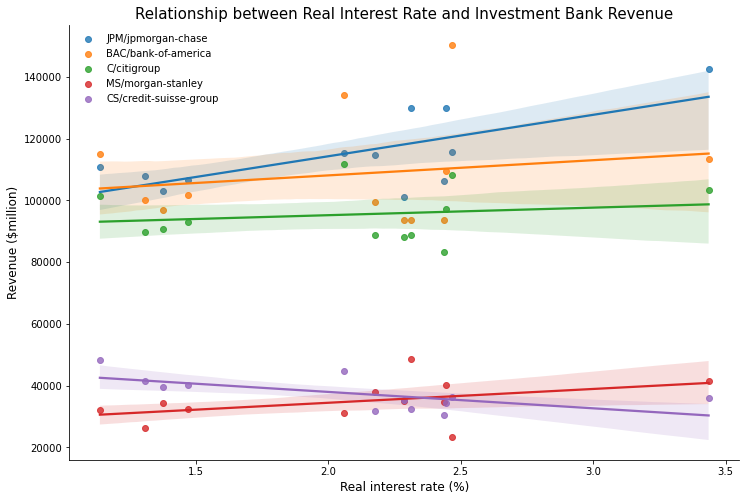

In [25]:
fig, ax = plt.subplots(figsize=(12,8))

for b in banks:
    sns.regplot(x=profit_vs_interest["Real interest rate (%)"], 
                y=profit_vs_interest[b], 
                data=profit_vs_interest, 
                ci = 90,
                ax=ax, label=b)
    
ax.set_xlabel("Real interest rate (%)", fontsize = 12)
ax.set_ylabel("Revenue ($million)",fontsize = 12)
ax.set_title("Relationship between Real Interest Rate and Investment Bank Revenue", fontsize = 15)
ax.legend(loc = "upper left", frameon=False)

sns.despine(ax = ax)  
plt.show()

In [26]:
# Get equation for regression line
for col in banks:
    x_vals = profit_vs_interest["Real interest rate (%)"]
    y_vals = profit_vs_interest[col]
    coeffs = np.polyfit(x_vals, y_vals, deg=1)
    print(f"{col}: y = {coeffs[0]:.2f}x + {coeffs[1]:.2f}")


JPM/jpmorgan-chase: y = 13416.70x + 87482.11
BAC/bank-of-america: y = 4918.90x + 98284.47
C/citigroup: y = 2445.05x + 90340.75
MS/morgan-stanley: y = 4471.91x + 25535.84
CS/credit-suisse-group: y = -5307.52x + 48606.93
